## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Бетев Иван

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов (1 балл)

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

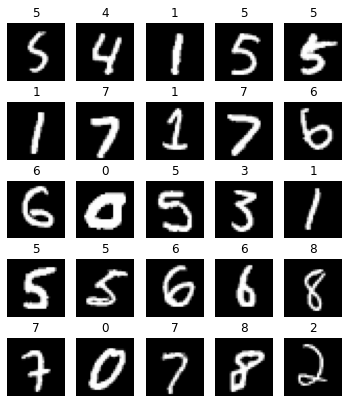

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [ ]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
# layer = nn.Linear(28*28, 10)
# layer.register_forward_hook(forward_hook)
# layer.register_backward_hook(backward_hook)
# init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

def full_init_layer(layer):
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, 0.1)
    return layer


layers = []
layers.append(nn.Sequential(full_init_layer(nn.Linear(784, 500)), nn.Tanh()))
for i in range(9):
    layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 500)), nn.Tanh()))
    
layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 10)), nn.Tanh(), nn.LogSoftmax(dim=1)))
network = nn.Sequential(*layers)
network

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (2): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (3): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (4): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (5): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (6): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (7): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (8): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True)
    (1): Tanh()
  )
  (9): Sequential(
    (0): Linear(in_features=500, out_features=500, bias=True

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [ ]:
#network = nn.Sequential(layer)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.989129364490509
forward 0.847170889377594
forward 0.7866596579551697
forward 0.7722333073616028
forward 0.7676901817321777
forward 0.7644439935684204
forward 0.7657047510147095
forward 0.765712559223175
forward 0.766754686832428
forward 0.7676509618759155
forward 0.7639625668525696
backward 0.017424194142222404
backward 0.0028265295550227165
backward 0.0033919550478458405
backward 0.004275897983461618
backward 0.005059464834630489
backward 0.006199618335813284
backward 0.007727581076323986
backward 0.009050444699823856
backward 0.011191705241799355
backward 0.01282503642141819
backward 0.01273518055677414


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


##### Дисперсия у активации сначала уменьшалась, но позже стабилизировалась. С градиентами же вышло все по разному

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

##### He

$W^i \sim N(0, \frac{2}{n_i})$

In [ ]:
def init_layer(layer, std):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)
    
    
def full_init_layer(layer, n_i):
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 2 / n_i)
    return layer
    
layers = []
layers.append(nn.Sequential(full_init_layer(nn.Linear(784, 500), 784), nn.Tanh()))
for i in range(9):
    layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 500), 500), nn.Tanh()))
    
layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 10), 500), nn.Tanh(), nn.LogSoftmax(dim=1)))
network = nn.Sequential(*layers)

In [ ]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.989129364490509
forward 0.07058420032262802
forward 0.00635673850774765
forward 0.000571775424759835
forward 5.22309128427878e-05
forward 4.6968948481662665e-06
forward 4.195236442683381e-07
forward 3.764223066582417e-08
forward 3.287374816807187e-09
forward 2.954897437845716e-10
forward 2.6269894246033765e-11
backward 0.02905932627618313
backward 0.0003482857719063759
backward 3.163905785186216e-05
backward 2.759089738901821e-06
backward 2.5109753210017516e-07
backward 2.2412811162553226e-08
backward 1.9514450055879706e-09
backward 1.7510767835737795e-10
backward 1.585609074594707e-11
backward 1.4549549716066923e-12
backward 1.39196122618708e-13


##### Получился полный разнобой с дисперсиями. Попробую ReLU, ведь He хорошо работает для нее

In [ ]:
layers = []
layers.append(nn.Sequential(full_init_layer(nn.Linear(784, 500), 784), nn.ReLU()))
for i in range(9):
    layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 500), 500), nn.ReLU()))
    
layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 10), 500), nn.ReLU(), nn.LogSoftmax(dim=1)))
network = nn.Sequential(*layers)


n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.989129364490509
forward 0.041821904480457306
forward 0.0026264404878020287
forward 0.00016138236969709396
forward 1.0549238140811212e-05
forward 6.842020638941904e-07
forward 4.414150822640295e-08
forward 2.6905142558319994e-09
forward 1.7603414559363983e-10
forward 1.1462218327262796e-11
forward 7.193564320606693e-13
backward 0.0221522506326437
backward 0.0002185843331972137
backward 1.4969320545787923e-05
backward 9.887479563985835e-07
backward 6.219002557372733e-08
backward 4.028292366342612e-09
backward 2.4141061372162653e-10
backward 1.6070244093779884e-11
backward 1.0627917816641297e-12
backward 6.677406023947174e-14
backward 4.25075353063277e-15


##### Тоже самое...

##### Xaveir

$U^i \sim U[-\frac{\sqrt{6}}{\sqrt{n_i + n_{i+1}}}; \frac{\sqrt{6}}{\sqrt{n_i + n_{i+1}}}]$

In [ ]:
def init_layer(layer, bounder):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-bounder, bounder)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)
    
    
def full_init_layer(layer, n_in, n_out):
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    bounder = np.sqrt(6 / (n_in + n_out))
    init_layer(layer, bounder)
    return layer
    
layers = []
layers.append(nn.Sequential(full_init_layer(nn.Linear(784, 500), 784, 500), nn.Tanh()))
for i in range(9):
    layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 500), 500, 500), nn.Tanh()))
    
layers.append(nn.Sequential(full_init_layer(nn.Linear(500, 10), 500, 10), nn.Tanh(), nn.LogSoftmax(dim=1)))
network = nn.Sequential(*layers)

In [ ]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.989129364490509
forward 0.6485909223556519
forward 0.49114200472831726
forward 0.41381579637527466
forward 0.35462141036987305
forward 0.3174775242805481
forward 0.29210981726646423
forward 0.2718641459941864
forward 0.2535313069820404
forward 0.23903559148311615
forward 0.22495338320732117
backward 0.0268268845975399
backward 0.004715523682534695
backward 0.004504924640059471
backward 0.004370417911559343
backward 0.004175322130322456
backward 0.003915715496987104
backward 0.0034783659502863884
backward 0.0032611056230962276
backward 0.0026803959626704454
backward 0.00229524914175272
backward 0.0017001550877466798


##### Выглядит лучше, но очень похоже на ситуацию с шумом

<i> 1.4 Сделайте выводы по первой части </i>

##### В целом было видно, что дисперсии стараются быть одинаковыми, только с He как-то не оч вышло...

### Часть 2: Dropout (1 балл)

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [ ]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        if self.training:
            mask = torch.autograd.Variable(torch.ones_like(self.linear.weight),
                                           requires_grad=False)
            mask.bernoulli_(self.p)
        else:
            mask = torch.autograd.Variable(torch.ones_like(self.linear.weight),
                                           requires_grad=False)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [6]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [7]:
from train_utils import train

Epoch 9... (Train/Test) NLL: 0.149/0.074	Accuracy: 0.956/0.978


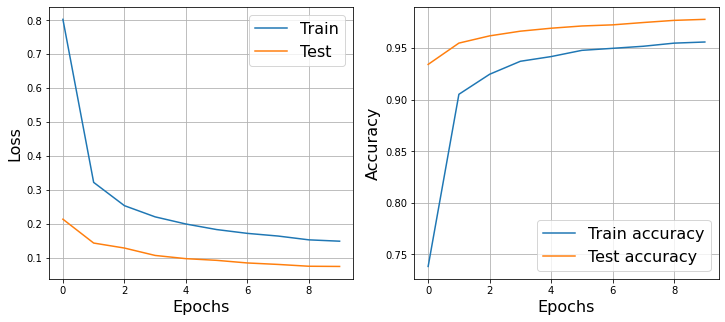

([0.8029962213181737,
  0.32220989993132,
  0.2535402209901098,
  0.22051504031935734,
  0.19943910249387786,
  0.18307284894051837,
  0.17181208045053076,
  0.16392953020296117,
  0.15273222055580063,
  0.14875336402435418],
 [0.21362120535554766,
  0.14328680423241627,
  0.1285459203527698,
  0.10672399807202665,
  0.09725117251937147,
  0.09228647743127769,
  0.08457219994426528,
  0.0802188110537827,
  0.07486235194757015,
  0.07428374872366085],
 [0.7383062,
  0.9053338,
  0.92477345,
  0.93737227,
  0.94193095,
  0.94797224,
  0.9499322,
  0.9519423,
  0.9549685,
  0.9560679],
 [0.9343355,
  0.955004,
  0.96202534,
  0.9665744,
  0.96944225,
  0.9716179,
  0.9727057,
  0.97498024,
  0.977057,
  0.9780459])

In [ ]:
layers = []
for n_in, n_out in [(196, 128), (128, 128)]:
    layers.append(nn.Sequential(nn.Linear(n_in, n_out), nn.Dropout(), nn.ReLU()))
layers.append(nn.Linear(128, 10))


network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

Epoch 9... (Train/Test) NLL: 0.121/0.174	Accuracy: 0.962/0.975


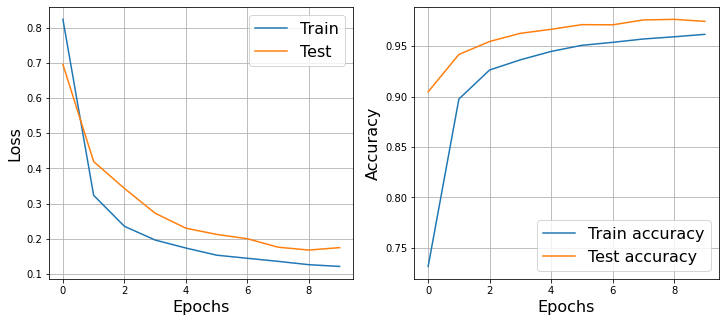

([0.8242517912438684,
  0.3233428517066594,
  0.23520567042550553,
  0.19613636690956443,
  0.1733377901301074,
  0.15299972072879134,
  0.14415249481860762,
  0.13542792201836482,
  0.1259531582008674,
  0.12094063712343542],
 [0.6959500637235521,
  0.41947649353289906,
  0.34307189530374693,
  0.27247636583692664,
  0.22977454334355984,
  0.2121864853594806,
  0.19979579440764553,
  0.17572462946011486,
  0.16759823815516914,
  0.1744629161567221],
 [0.7315598,
  0.8976268,
  0.92644477,
  0.9365227,
  0.94484055,
  0.95092064,
  0.95384127,
  0.9571895,
  0.95934945,
  0.9617982],
 [0.9047666,
  0.94185126,
  0.95470726,
  0.9628165,
  0.96677214,
  0.9714201,
  0.9712223,
  0.976068,
  0.9766614,
  0.9746835])

In [ ]:
layers = []
for n_in, n_out in [(196, 128), (128, 128)]:
    layers.append(nn.Sequential(DropConnect(n_in, n_out), nn.ReLU()))
layers.append(nn.Linear(128, 10))


network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 2.3 Сделайте выводы по третьей части. </i>

##### Как видим, что Dropout, что DropConnect помогают сетке плавно сходиться и не переобучаться. Думаю с такой архитектурой и данным датасетом оно было даже очень вероятно

### Часть 3: Batch Normalization (3 балла)

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [8]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(0)) / x.std(0)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.021/0.047	Accuracy: 0.993/0.985


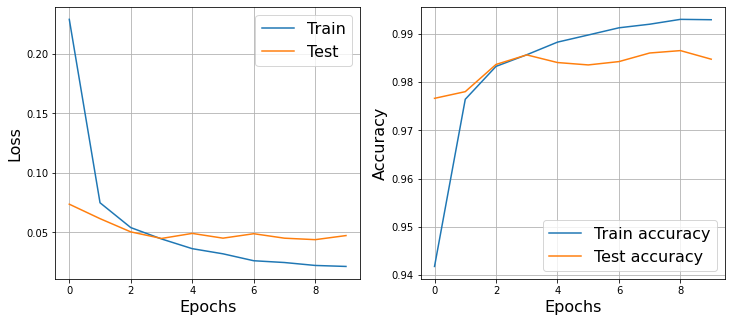

([0.22905293978385324,
  0.07488907864496017,
  0.05402796115897008,
  0.044468912222523936,
  0.03630806817742648,
  0.03198405012869632,
  0.026162714844367017,
  0.02466653076349013,
  0.022206623289636823,
  0.021371333051903814],
 [0.07370289188774326,
  0.06153923349714355,
  0.050415779346057885,
  0.04490130028652051,
  0.049141534338882076,
  0.045149661966045446,
  0.04888020336032621,
  0.045121817687479186,
  0.04388735294666236,
  0.04732003776191533],
 [0.94183105,
  0.97646254,
  0.98328114,
  0.98569095,
  0.9883062,
  0.9897832,
  0.99127686,
  0.9920209,
  0.9930259,
  0.99294823],
 [0.9766614,
  0.9780459,
  0.98368275,
  0.9856606,
  0.98407835,
  0.98358387,
  0.9842761,
  0.98605615,
  0.9865506,
  0.9847706])

In [13]:
layers = []
for n_in, n_out in [(196, 128), (128, 128)]:
    layers.append(nn.Sequential(nn.Linear(n_in, n_out), nn.BatchNorm1d(n_out), nn.ReLU()))
layers.append(nn.Linear(128, 10))


network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.019/0.055	Accuracy: 0.994/0.981


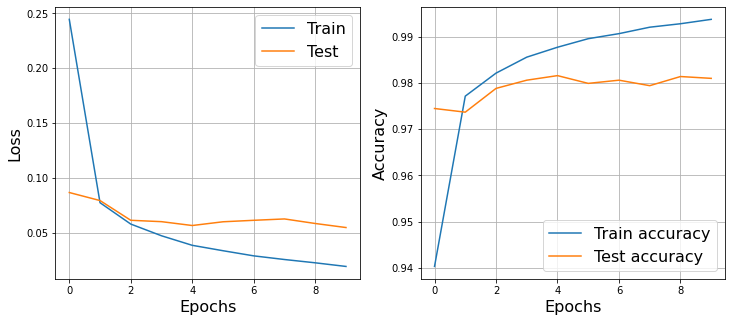

([0.2446084482742271,
  0.07738511842975357,
  0.05790277313726988,
  0.04722971294019649,
  0.03852547130891001,
  0.03360047852590696,
  0.028910552278589973,
  0.02557822080107648,
  0.022573728099969752,
  0.01925912187017723],
 [0.08667048979314822,
  0.07935110827365631,
  0.06135312008046651,
  0.060096805820925324,
  0.05659069610123016,
  0.05999678106907802,
  0.0613427948165402,
  0.06258342369117692,
  0.05843270868298751,
  0.05474367653184771],
 [0.94029295,
  0.9771622,
  0.98214287,
  0.98560214,
  0.987751,
  0.9896,
  0.9906938,
  0.99208754,
  0.99283713,
  0.99378663],
 [0.97448575,
  0.9736946,
  0.978837,
  0.9806171,
  0.981606,
  0.97992486,
  0.9806171,
  0.9794304,
  0.98140824,
  0.98101264])

In [14]:
layers = []
for n_in, n_out in [(196, 128), (128, 128)]:
    layers.append(nn.Sequential(nn.Linear(n_in, n_out), LayerNormalization(), nn.ReLU()))
layers.append(nn.Linear(128, 10))


network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

##### Здесь же получаем моментальное переобучение, неудивительно, что такая сетка легко выучила обучающую выборку)) Можно сказать, что данные нормализации являются очень мощным инструментом и на более сложных примерах будут очень хорошо помогать сетке сходиться

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: